In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg',cache_subdir=os.getcwd())
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',cache_subdir=os.getcwd())

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

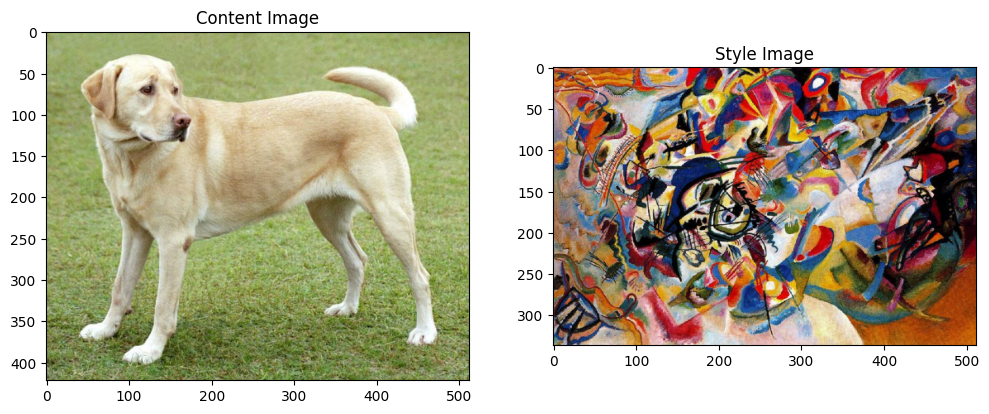

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [22]:
tf.constant(content_image)

<tf.Tensor: shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[0.6290779 , 0.64868575, 0.38986227],
         [0.6007131 , 0.62248087, 0.3679772 ],
         [0.5896757 , 0.61320513, 0.3622247 ],
         ...,
         [0.5269978 , 0.55837035, 0.32699776],
         [0.49909073, 0.5304633 , 0.29732907],
         [0.47968566, 0.5110583 , 0.27576408]],

        [[0.6060711 , 0.6300001 , 0.36901602],
         [0.60180223, 0.62551117, 0.3700369 ],
         [0.6003996 , 0.623929  , 0.37294865],
         ...,
         [0.52357244, 0.554945  , 0.32141185],
         [0.5284101 , 0.5597826 , 0.3254584 ],
         [0.53133637, 0.5627089 , 0.3274148 ]],

        [[0.58011585, 0.60756683, 0.3448217 ],
         [0.5973071 , 0.6225982 , 0.36633283],
         [0.60061604, 0.6340622 , 0.3797762 ],
         ...,
         [0.530031  , 0.5614036 , 0.32610947],
         [0.5510388 , 0.58241135, 0.34711725],
         [0.55976367, 0.5911362 , 0.35584208]],

        ...,

        [[0.43124956, 0.40153953, 

Fast Style Transfer using TF-Hub
This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details

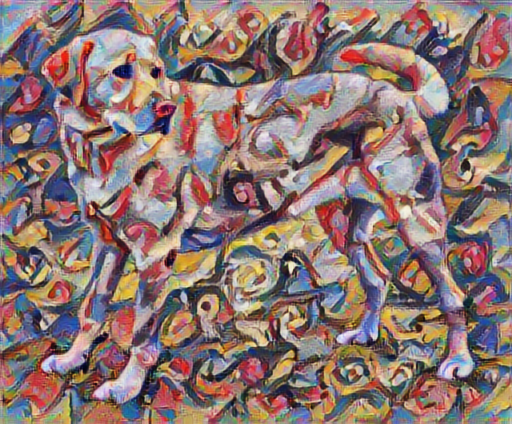

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Define content and style representations
Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)

In [10]:
x

<tf.Tensor: shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[ -4.524124 ,  48.63587  ,  36.73487  ],
         [-10.10482  ,  41.95362  ,  29.501839 ],
         [-11.571709 ,  39.58831  ,  26.68731  ],
         ...,
         [-20.554573 ,  25.605446 ,  10.704445 ],
         [-28.120094 ,  18.489143 ,   3.5881348],
         [-33.619164 ,  13.540855 ,  -1.3601532]],

        [[ -9.83992  ,  43.871025 ,  30.868141 ],
         [ -9.57959  ,  42.72634  ,  29.779564 ],
         [ -8.837097 ,  42.3229   ,  29.421898 ],
         ...,
         [-21.978981 ,  24.731972 ,   9.830971 ],
         [-20.947105 ,  25.965569 ,  11.064568 ],
         [-20.448227 ,  26.71177  ,  11.810768 ]],

        [[-16.009468 ,  38.150536 ,  24.24955  ],
         [-10.524132 ,  41.98353  ,  28.633308 ],
         [ -7.0960693,  44.906853 ,  29.477089 ],
         ...,
         [-20.78109  ,  26.378914 ,  11.477913 ],
         [-15.424103 ,  31.735893 ,  16.834892 ],
         [-13.199272 ,  33.96073  ,  19.05973 

In [11]:
x = tf.image.resize(x, (224, 224))

In [21]:
x

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[ -8.801555  ,  43.80758   ,  31.23794   ],
         [ -3.3201537 ,  46.91127   ,  30.959774  ],
         [ 10.250625  ,  59.694942  ,  40.16895   ],
         ...,
         [-23.171505  ,  21.363684  ,   6.462689  ],
         [-21.019142  ,  25.158255  ,  10.257255  ],
         [-25.967201  ,  20.924969  ,   6.023963  ]],

        [[-13.0738945 ,  39.718273  ,  25.404175  ],
         [ -4.788845  ,  46.259747  ,  29.90681   ],
         [  8.037533  ,  58.967346  ,  39.52311   ],
         ...,
         [-14.135152  ,  32.041187  ,  16.4884    ],
         [-18.09348   ,  28.766468  ,  13.213692  ],
         [-13.957483  ,  33.94943   ,  18.396646  ]],

        [[-15.827937  ,  35.42919   ,  19.00702   ],
         [-11.070037  ,  42.070057  ,  24.204107  ],
         [ -2.1710446 ,  50.595463  ,  31.00231   ],
         ...,
         [-10.3856945 ,  37.33857   ,  20.429115  ],
         [ -6.1706676 ,  42.105103  ,  25.195652

In [12]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [13]:
vgg

<Functional name=vgg19, built=True>

In [16]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
prediction_probabilities = vgg(x)

In [ ]:
prediction_probabilities

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[5.04436275e-06, 9.61996420e-07, 5.77932894e-07, 3.82552827e-07,
        2.57796910e-06, 7.98494057e-07, 1.78659519e-07, 6.15208410e-06,
        9.34750733e-06, 8.33417857e-07, 4.41754480e-07, 2.68664962e-06,
        8.75452542e-07, 1.02521824e-06, 4.64458765e-07, 2.29224909e-07,
        3.68974412e-07, 1.34848028e-06, 7.04490617e-07, 6.82964810e-07,
        2.89850902e-07, 1.20562811e-06, 2.35860375e-06, 2.30305045e-06,
        9.05008335e-07, 7.76994568e-07, 9.43231441e-07, 1.11489283e-06,
        1.35328435e-06, 1.44854994e-06, 5.93417042e-07, 1.99397959e-06,
        8.80274797e-07, 5.29665726e-07, 9.22724212e-07, 3.58108281e-07,
        5.31669855e-07, 1.14267675e-06, 1.06625043e-06, 8.47636102e-07,
        4.17533147e-06, 4.81217796e-07, 4.06014323e-07, 3.13900728e-07,
        8.41473025e-07, 3.21945578e-07, 2.42070882e-06, 1.37596089e-06,
        2.74439429e-07, 6.17266267e-07, 1.07233529e-06, 9.57499651e-07,
        2.294

In [17]:
prediction_probabilities.shape

TensorShape([1, 1000])

In [18]:
vgg1 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [19]:
vgg1.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tf.keras.applications import VGG16

# Load the pre-trained VGG16 model
vgg1 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the VGG16 model
vgg1.trainable = False


TypeError: VGG19() got an unexpected keyword argument 'traning'

In [ ]:
for layer in vgg1.layers[:10]:  # Freeze the first 10 layers
    layer.trainable = False


In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten

# # Load VGG16 with pre-trained ImageNet weights
# vgg1 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# # Freeze all VGG16 layers
# vgg1.trainable = False

# # Build a custom model on top of VGG16
# model = Sequential([
#     vgg1,
#     Flatten(),
#     Dense(256, activation="relu"),
#     Dense(10, activation="softmax")  # 10 classes
# ])

# # Compile the model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # Train the model (only custom layers are trainable)
# model.fit(train_data, train_labels, epochs=10)

# # Unfreeze VGG16 layers for fine-tuning
# vgg1.trainable = True

# # Recompile the model after changing trainable layers
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # Continue training with fine-tuning
# model.fit(train_data, train_labels, epochs=5)


In [24]:
tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())

[[('n02099712', 'Labrador_retriever', 0.49317157),
  ('n02099601', 'golden_retriever', 0.23665272),
  ('n02104029', 'kuvasz', 0.03635751),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.02418279),
  ('n02107574', 'Greater_Swiss_Mountain_dog', 0.018646086)]]

In [25]:
tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]

[('n02099712', 'Labrador_retriever', 0.49317157),
 ('n02099601', 'golden_retriever', 0.23665272),
 ('n02104029', 'kuvasz', 0.03635751),
 ('n02099849', 'Chesapeake_Bay_retriever', 0.02418279),
 ('n02107574', 'Greater_Swiss_Mountain_dog', 0.018646086)]

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317157),
 ('golden_retriever', 0.23665272),
 ('kuvasz', 0.03635751),
 ('Chesapeake_Bay_retriever', 0.02418279),
 ('Greater_Swiss_Mountain_dog', 0.018646086)]

In [26]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [27]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

Choose intermediate layers from the network to represent the style and content of the image:

In [28]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

Build the model
The networks in tf.keras.applications are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

In [30]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [31]:
# model = tf.keras.Model(inputs, outputs)

In [32]:
style_extractor = vgg_layers(style_layers)

In [33]:
style_extractor

<Functional name=functional, built=True>

In [34]:
style_outputs = style_extractor(style_image*255)

d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_70']. Received: the structure of inputs=*
  warnings.warn(


In [35]:


#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.13
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



Calculate style
The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msubsup>
    <mi>G</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>c</mi>
      <mi>d</mi>
    </mrow>
    <mi>l</mi>
  </msubsup>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <munder>
        <mo>&#x2211;<!-- ∑ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>i</mi>
          <mi>j</mi>
        </mrow>
      </munder>
      <msubsup>
        <mi>F</mi>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>i</mi>
          <mi>j</mi>
          <mi>c</mi>
        </mrow>
        <mi>l</mi>
      </msubsup>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo stretchy="false">)</mo>
      <msubsup>
        <mi>F</mi>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>i</mi>
          <mi>j</mi>
          <mi>d</mi>
        </mrow>
        <mi>l</mi>
      </msubsup>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo stretchy="false">)</mo>
    </mrow>
    <mrow>
      <mi>I</mi>
      <mi>J</mi>
    </mrow>
  </mfrac>
</math>

This can be implemented concisely using the tf.linalg.einsum function:

In [37]:
# . Input Tensor
# The input_tensor is expected to have the shape:
# [batch_size, height, width, channels],
# where:

# batch_size: Number of samples in the batch.
# height and width: Spatial dimensions of the feature maps.
# channels: Number of feature maps (depth of the tensor).
# Example:
# A tensor with shape [2, 64, 64, 512] represents a batch of 2 images, with feature maps of size 
# 64 × 64
# 64×64 and 512 channels.



In [ ]:
# Here, tf.linalg.einsum is used to compute the Gram matrix efficiently. Let’s break down the Einstein summation:

# bijc: Refers to the feature map at location (i, j) in the c-th channel for each batch b.
# bijd: Refers to the feature map at location (i, j) in the d-th channel for each batch b.
# ->bcd: Specifies that we are computing the relationship between channels c and d for each batch b.
# The operation computes the sum of elementwise products across the spatial dimensions (i, j). This gives a tensor of shape: [batch_size, channels, channels].

# The resulting Gram matrix at each batch index 
# 𝑏
# b contains the pairwise correlations between channels of the feature maps.
# 3. Input Shape and Normalization
# python
# Copy code
# input_shape = tf.shape(input_tensor)
# num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
# input_shape[1] and input_shape[2] are the spatial dimensions 
# height
# height and 
# width
# width of the feature maps.
# num_locations is the total number of spatial locations (pixels) in the feature maps:
# num_locations
# =
# height
# ×
# width
# num_locations=height×width
# Normalization:

# python
# Copy code
# return result / (num_locations)
# The result is divided by the total number of spatial locations to normalize the Gram matrix. This ensures the magnitude of the Gram matrix is not affected by the size of the feature maps.
# Purpose
# In style transfer:

# The Gram matrix captures the style of an image by measuring correlations between feature maps.
# Normalizing by the number of spatial locations ensures that the style representation is consistent regardless of the size of the image or feature map.
# Example
# Input:
# A batch of feature maps with shape [2, 4, 4, 3]:

# Batch size = 2.
# Feature map dimensions = 
# 4
# ×
# 4
# 4×4.
# Number of channels = 3.
# Output:
# The Gram matrix will have shape [2, 3, 3].
# Each matrix in the batch represents the channel-wise correlations of the feature maps, normalized by 
# 4
# ×
# 4
# =
# 16
# 4×4=16.
# Let me know if you’d like a practical implementation example!

In [36]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Extract style and content
Build a model that returns the style and content tensors

In [38]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [39]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_92']. Received: the structure of inputs=*
  warnings.warn(


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228476
    max:  28014.564
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.48
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.3
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.39
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8792
    mean:  13.764152


Run gradient descent
With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [42]:
content_targets

{'block5_conv2': <tf.Tensor: shape=(1, 26, 32, 512), dtype=float32, numpy=
 array([[[[  0.       ,   0.       , 104.960396 , ...,   0.       ,
            73.79443  ,   5.6548915],
          [  0.       ,   0.       ,   0.       , ...,   0.       ,
           148.57489  ,   0.       ],
          [  0.       ,   0.       ,   0.       , ...,   7.1964827,
           170.16641  ,   0.       ],
          ...,
          [  0.       ,   0.       ,   0.       , ...,   0.       ,
            89.4836   ,   3.8054125],
          [  0.       ,   0.       ,  10.147292 , ...,   0.       ,
            87.92328  ,   0.       ],
          [  0.       ,   0.       ,   0.       , ...,   0.       ,
            77.2627   ,   0.       ]],
 
         [[  0.       ,   0.       ,  73.48951  , ...,  16.2877   ,
             0.       ,   0.       ],
          [  0.       ,   0.       ,   0.       , ...,   0.       ,
             6.1247816,   0.       ],
          [  0.       ,   0.       ,   0.       , ...,   0.

In [41]:
style_targets

{'block1_conv1': <tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
 array([[[ 5166.24   ,   605.1933 ,   824.5506 , ...,  1739.0231 ,
           1467.1729 ,  2504.0784 ],
         [  605.1933 ,  1162.9904 ,   597.47626, ...,   518.7833 ,
            403.55716,   503.52966],
         [  824.5506 ,   597.47626,   635.471  , ...,   100.54672,
            615.1243 ,   898.81586],
         ...,
         [ 1739.0231 ,   518.7833 ,   100.54672, ..., 11164.048  ,
           1034.8027 ,   778.86206],
         [ 1467.1731 ,   403.55716,   615.1243 , ...,  1034.8029 ,
           2300.466  ,  2206.1821 ],
         [ 2504.0786 ,   503.52966,   898.81604, ...,   778.86206,
           2206.1821 ,  2829.5212 ]]], dtype=float32)>,
 'block2_conv1': <tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
 array([[[1.5257650e+03, 2.3076326e+02, 1.5033583e+01, ...,
          1.5111439e+03, 1.0906848e+03, 5.0436630e+02],
         [2.3076326e+02, 5.0887332e+04, 2.3263078e+04, ...,
          5.1740160e+04, 

What is tf.Variable?
In TensorFlow, a tf.Variable is a mutable tensor, meaning its value can be changed during execution. Unlike a standard tensor (e.g., tf.constant), it is designed to be updated during computations, such as during gradient descent or optimization.

In [ ]:
image = tf.Variable(content_image)

In [44]:
image

<tf.Variable 'Variable:0' shape=(1, 422, 512, 3) dtype=float32, numpy=
array([[[[0.6290779 , 0.64868575, 0.38986227],
         [0.6007131 , 0.62248087, 0.3679772 ],
         [0.5896757 , 0.61320513, 0.3622247 ],
         ...,
         [0.5269978 , 0.55837035, 0.32699776],
         [0.49909073, 0.5304633 , 0.29732907],
         [0.47968566, 0.5110583 , 0.27576408]],

        [[0.6060711 , 0.6300001 , 0.36901602],
         [0.60180223, 0.62551117, 0.3700369 ],
         [0.6003996 , 0.623929  , 0.37294865],
         ...,
         [0.52357244, 0.554945  , 0.32141185],
         [0.5284101 , 0.5597826 , 0.3254584 ],
         [0.53133637, 0.5627089 , 0.3274148 ]],

        [[0.58011585, 0.60756683, 0.3448217 ],
         [0.5973071 , 0.6225982 , 0.36633283],
         [0.60061604, 0.6340622 , 0.3797762 ],
         ...,
         [0.530031  , 0.5614036 , 0.32610947],
         [0.5510388 , 0.58241135, 0.34711725],
         [0.55976367, 0.5911362 , 0.35584208]],

        ...,

        [[0.43124956,

In [45]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [47]:
style_weight=1e-2
content_weight=1e4

What is Style Loss?
In style transfer, style loss measures how different the style of the generated image is compared to the target style image. It compares the Gram matrices of feature maps from specific layers of the neural network for the generated and target style images.

style_outputs: A dictionary containing the Gram matrices of the generated image's feature maps, extracted from specific layers of a pre-trained model.
style_targets: A dictionary containing the Gram matrices of the target style image's feature maps, computed in the same layers.

In [51]:
# [tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()]

This creates a list of the style loss values for each layer, calculated as:

MSE
=
1
𝑁
∑
𝑖
=
1
𝑁
(
style_outputs
[
𝑛
𝑎
𝑚
𝑒
]
[
𝑖
]
−
style_targets
[
𝑛
𝑎
𝑚
𝑒
]
[
𝑖
]
)
2
MSE= 
N
1
​
  
i=1
∑
N
​
 (style_outputs[name][i]−style_targets[name][i]) 
2
 
Here:

name iterates over the keys (layer names) in style_outputs.
style_outputs[name] and style_targets[name] are the Gram matrices for a specific layer.
(style_outputs[name] - style_targets[name])**2:

Combines all the individual layer losses into a single scalar by summing them.
The result is the total style loss, aggregated across all the selected layers.

In [54]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use tf.GradientTape to update the image.

The train_step function implements a single optimization step for neural style transfer. It adjusts the image being generated to minimize the style and content loss. Here's a detailed explanation of each part:

mage: This is the current version of the generated image. It is typically a tf.Variable so that it can be updated during training.

In [ ]:
# @tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

tf.GradientTape:
TensorFlow's GradientTape is used to record operations on tensors and compute their gradients with respect to some variables.
Here, the tape records operations involving the image.

extractor(image):
extractor is likely a feature extraction model (e.g., based on VGG). It processes the image and returns:
Style features for specific layers (for style loss).
Content features for specific layers (for content loss).

style_content_loss(outputs):
This function computes the total loss:
Style Loss: Measures how different the style of the generated image is from the target style.
Content Loss: Measures how different the content of the generated image is from the target content.

ape.gradient(loss, image):
Computes the gradient of the loss with respect to the image.
The gradient indicates how to adjust the pixel values of the image to minimize the loss.

opt: This is the optimizer (e.g., Adam optimizer) used to apply gradients. It updates the image to reduce the loss.
opt.apply_gradients([(grad, image)]):
Applies the computed gradients (grad) to the image.
Updates the pixel values of the image to better match the target style and content.

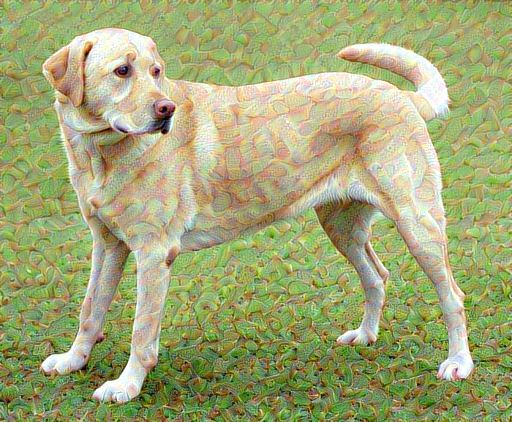

In [57]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Why Clip the Image?
After applying gradients, some pixel values may fall outside the valid range 
[
0
,
1
]
[0,1].
clip_0_1(image) ensures that all pixel values remain within the range:

Since it's working, perform a longer optimization:

In [58]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

....................................

KeyboardInterrupt: 